**сиамская сеть, оцениваем схожесть текстов**

Евгений Борисов <esborisov@sevsu.ru>

## Библиотеки

In [1]:
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
# import gzip
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200  
tqdm.pandas()

def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
# каталог товаров
data = pd.read_excel('../data/okpd2.xlsx')
ppr(data)
data.sample(3)

записей: 19 464


,Код,Наименование,Комментарий
5260,47.91.20,"Услуги по розничной торговле, осуществляемые непосредственно при помощи информационно-коммуникационной сети Интернет",NaN
12791,24.45.30.234,Сплавы на основе циркония,NaN
11469,20.16.59.270,Оксиэтилцеллюлоза в первичных формах,NaN


In [4]:
# нумеруем позиции каталога
data['id'] = range(len(data))
# будем использовать второй уровень каталога (две первые цифры)
data['group'] = data['Код'].str[:5]

In [5]:
# длина описаний в символах
data['Наименование'].str.len().describe([.95]).astype(int)

count    19464
mean        58
std         39
min          3
50%         50
95%        130
max        540
Name: Наименование, dtype: int64

In [6]:
# выкидываем короткие описания и дубликаты
data = data[ (data['group'].str.len()==5) & data['Наименование'].str.len().between(30,100) ]\
  .drop_duplicates(['Наименование'])[['id','group','Наименование']]\
  .reset_index(drop=True)

ppr(data)
data.sample(3)

записей: 9 632


,id,group,Наименование
6005,11933,22.19,"Шланги из вулканизированной резины, кроме твердой резины (эбонита)"
2147,4643,30.11,"Операции процесса производства судов и плавучих конструкций отдельные, выполняемые субподрядчиком"
7459,14967,29.32,"Муфты выключения сцеплений, подшипники муфт выключения сцеплений"


In [7]:
# формируем списки описаний по группам
groups =  data[['id','group']].groupby('group')['id'].apply(list).reset_index()
ppr(groups)

записей: 596


In [8]:
# количество описаний в группах
groups['id'].str.len().describe([.95]).astype(int)

count    596
mean      16
std       24
min        1
50%        7
95%       62
max      185
Name: id, dtype: int64

In [9]:
# выкидываем группы с малым количеством описаний, обрезаем большие списки
n_samples = 10

ppr(groups)
groups = groups[ groups['id'].str.len()> n_samples ].reset_index(drop=True)
ppr(groups)
groups['id'] = groups['id'].apply(rng.permutation).str[:n_samples]

записей: 596
записей: 227


In [10]:
# похожие примеры
groups['id_eq'] = groups['id'].apply(rng.permutation)

In [11]:
groups

,group,id,id_eq
0,01.11,"[6061, 2854, 6068, 6118, 18536, 2827, 6063, 18534, 6144, 6073]","[6073, 6061, 6144, 2854, 6063, 18536, 6068, 18534, 6118, 2827]"
1,01.13,"[2866, 6207, 6238, 6239, 6219, 6224, 744, 6225, 6230, 6222]","[6239, 6224, 744, 2866, 6230, 6207, 6238, 6219, 6222, 6225]"
2,01.15,"[18166, 18177, 18165, 18164, 18169, 18178, 18168, 18167, 18175, 6246]","[18164, 18177, 18166, 18169, 18175, 18167, 18168, 18165, 18178, 6246]"
3,01.16,"[747, 2887, 6264, 6250, 6253, 6272, 6270, 6271, 6258, 6269]","[6250, 747, 6272, 6270, 6253, 6271, 6269, 6258, 2887, 6264]"
4,01.19,"[6287, 6285, 6297, 1384, 1385, 2891, 6275, 6295, 2894, 6284]","[6284, 6297, 2891, 6287, 2894, 6295, 1384, 6275, 1385, 6285]"
...,...,...,...
222,95.29,"[19278, 19267, 19277, 19288, 19307, 19283, 19300, 19284, 19317, 6015]","[19278, 19267, 19317, 19288, 19307, 6015, 19277, 19284, 19300, 19283]"
223,96.01,"[19380, 19382, 19387, 6023, 19360, 19395, 19400, 19349, 19402, 19385]","[19402, 6023, 19385, 19349, 19387, 19360, 19380, 19382, 19400, 19395]"
224,96.02,"[6026, 19415, 19412, 2818, 2817, 19414, 19411, 6025, 1353, 19410]","[19415, 6025, 19411, 2817, 6026, 2818, 1353, 19414, 19412, 19410]"
225,96.03,"[19430, 19425, 19429, 19441, 19437, 19439, 19435, 19443, 19433, 19442]","[19442, 19443, 19439, 19437, 19433, 19441, 19429, 19435, 19430, 19425]"


In [12]:
# непохожие примеры

# пары из разных групп
groups_ = groups[['group']].reset_index(drop=True)
groups_['group_neq'] = rng.permutation(groups['group'])
groups_ = groups_.query('group!=group_neq')

groups_ = groups_.merge( groups[['group','id']]\
                          .rename(columns={'group':'group_neq','id':'id_neq'}), 
                        on=['group_neq'])

groups_['id_neq'] = groups_['id_neq'].apply(rng.permutation)

# groups[['group','id']].rename(columns={'group':'group_neq','id':'id_neq'})

groups_

,group,group_neq,id_neq
0,01.11,30.92,"[2186, 15230, 1002, 2190, 15234, 15235, 15232, 15238, 15231, 15240]"
1,01.13,32.50,"[15740, 15717, 2221, 2218, 4746, 15748, 15724, 15723, 2217, 15739]"
2,01.15,01.42,"[6429, 6454, 6430, 6435, 6444, 6427, 6425, 6453, 6461, 6431]"
3,01.16,20.59,"[3771, 11712, 11674, 11666, 11692, 11699, 11704, 11683, 264, 11684]"
4,01.19,30.91,"[2185, 2184, 15222, 15224, 15217, 15214, 4677, 2183, 15215, 4676]"
...,...,...,...
222,95.29,28.30,"[14460, 4495, 2099, 4502, 4485, 4488, 4494, 4505, 14470, 14430]"
223,96.01,10.61,"[8573, 3222, 8570, 8571, 1528, 8542, 3225, 8578, 3224, 18036]"
224,96.02,28.14,"[18771, 18768, 2063, 14058, 2064, 18772, 4407, 18775, 14059, 18778]"
225,96.03,96.01,"[19349, 19385, 19402, 19395, 6023, 19360, 19382, 19380, 19387, 19400]"


In [13]:
# группа, описания, похожие описания, непохожие описания
groups = groups.merge( groups_[['group','id_neq']], on=['group'] )
groups

,group,id,id_eq,id_neq
0,01.11,"[6061, 2854, 6068, 6118, 18536, 2827, 6063, 18534, 6144, 6073]","[6073, 6061, 6144, 2854, 6063, 18536, 6068, 18534, 6118, 2827]","[2186, 15230, 1002, 2190, 15234, 15235, 15232, 15238, 15231, 15240]"
1,01.13,"[2866, 6207, 6238, 6239, 6219, 6224, 744, 6225, 6230, 6222]","[6239, 6224, 744, 2866, 6230, 6207, 6238, 6219, 6222, 6225]","[15740, 15717, 2221, 2218, 4746, 15748, 15724, 15723, 2217, 15739]"
2,01.15,"[18166, 18177, 18165, 18164, 18169, 18178, 18168, 18167, 18175, 6246]","[18164, 18177, 18166, 18169, 18175, 18167, 18168, 18165, 18178, 6246]","[6429, 6454, 6430, 6435, 6444, 6427, 6425, 6453, 6461, 6431]"
3,01.16,"[747, 2887, 6264, 6250, 6253, 6272, 6270, 6271, 6258, 6269]","[6250, 747, 6272, 6270, 6253, 6271, 6269, 6258, 2887, 6264]","[3771, 11712, 11674, 11666, 11692, 11699, 11704, 11683, 264, 11684]"
4,01.19,"[6287, 6285, 6297, 1384, 1385, 2891, 6275, 6295, 2894, 6284]","[6284, 6297, 2891, 6287, 2894, 6295, 1384, 6275, 1385, 6285]","[2185, 2184, 15222, 15224, 15217, 15214, 4677, 2183, 15215, 4676]"
...,...,...,...,...
222,95.29,"[19278, 19267, 19277, 19288, 19307, 19283, 19300, 19284, 19317, 6015]","[19278, 19267, 19317, 19288, 19307, 6015, 19277, 19284, 19300, 19283]","[14460, 4495, 2099, 4502, 4485, 4488, 4494, 4505, 14470, 14430]"
223,96.01,"[19380, 19382, 19387, 6023, 19360, 19395, 19400, 19349, 19402, 19385]","[19402, 6023, 19385, 19349, 19387, 19360, 19380, 19382, 19400, 19395]","[8573, 3222, 8570, 8571, 1528, 8542, 3225, 8578, 3224, 18036]"
224,96.02,"[6026, 19415, 19412, 2818, 2817, 19414, 19411, 6025, 1353, 19410]","[19415, 6025, 19411, 2817, 6026, 2818, 1353, 19414, 19412, 19410]","[18771, 18768, 2063, 14058, 2064, 18772, 4407, 18775, 14059, 18778]"
225,96.03,"[19430, 19425, 19429, 19441, 19437, 19439, 19435, 19443, 19433, 19442]","[19442, 19443, 19439, 19437, 19433, 19441, 19429, 19435, 19430, 19425]","[19349, 19385, 19402, 19395, 6023, 19360, 19382, 19380, 19387, 19400]"


In [14]:
# разворачиваем в список пар
groups = pd.DataFrame({'id':groups['id'].explode(), 
              'id_eq':groups['id_eq'].explode(),
              'id_neq':groups['id_neq'].explode()})
ppr(groups)
groups.sample(3)

записей: 2 270


,id,id_eq,id_neq
29,1506,8126,3018
211,5825,5825,13227
45,148,188,4699


In [15]:
# формируем датасет
pair = groups[['id','id_eq']].rename(columns={'id':'id_L','id_eq':'id_R'})
pair['target'] = 1
pair = pd.concat([ pair, groups[['id','id_neq']]\
           .rename(columns={'id':'id_L','id_neq':'id_R'}) ])\
           .fillna(0).astype(int)

pair.sample(3)

,id_L,id_R,target
135,14144,14151,1
107,13011,4095,1
112,4135,18803,0


In [16]:
%xdel groups
%xdel groups_

## очистка данных

In [17]:
# data['ttext_clean'] = data['ttext']\
#     .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
#     .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
#     .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

In [18]:
# data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [19]:
data['ttext_clean'] = data['Наименование'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9632/9632 [00:00<00:00, 131483.65it/s]


In [20]:
data.sample(3)

,id,group,Наименование,ttext_clean
2941,6288,01.19,Семенники кормовых корнеплодов,"[семенники, кормовых, корнеплодов]"
2551,5475,59.20,Услуги непосредственной звукозаписи,"[услуги, непосредственной, звукозаписи]"
8535,17613,84.23,Услуги федеральных арбитражных судов округов,"[услуги, федеральных, арбитражных, судов, округов]"


In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 9 632
записей: 9 632


In [22]:
data.sample(3)

,id,group,Наименование,ttext_clean
1445,3114,10.13,"Операции процесса производства мяса и мяса домашней птицы отдельные, выполняемые субподрядчиком","[операции, процесса, производства, мяса, и, мяса, домашней, птицы, отдельные, выполняемые, субподрядчиком]"
4323,8844,10.86,Колбасы вареные для детского питания,"[колбасы, вареные, для, детского, питания]"
6243,12338,23.99,"Смеси асфальтобетонные дорожные, аэродромные и асфальтобетон горячие песчаные","[смеси, асфальтобетонные, дорожные, аэродромные, и, асфальтобетон, горячие, песчаные]"


In [23]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 9 976


## кодируем слова

In [24]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9632/9632 [00:00<00:00, 405589.33it/s]


In [25]:
data[['ttext_clean','code']].sample(3)

,ttext_clean,code
9492,"[услуги, по, ремонту, трикотажных, изделий, комбинированных, с, тканями, искусственной, кожей, мехом, и, др]","[8968, 5911, 7148, 8719, 2460, 3108, 7317, 8561, 2628, 3033, 4157, 2416, 1955]"
7761,"[аксессуары, для, кукол, изображающих, людей, прочие]","[139, 1866, 3527, 2483, 3834, 6707]"
6830,"[динамометры, и, силоизмерительные, машины, образцовые]","[1821, 2416, 7588, 3995, 4951]"


In [26]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    9632
mean        7
std         2
min         2
25%         5
50%         7
75%         9
max        16
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

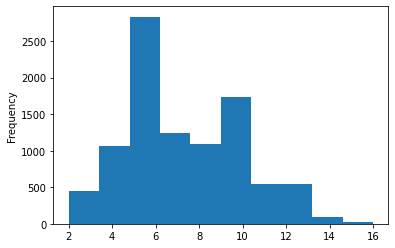

In [27]:
data['code'].str.len().plot.hist()

In [28]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

16

In [29]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9632/9632 [00:00<00:00, 574256.74it/s]


In [30]:
data['code'].str.len().describe().astype(int)

count    9632
mean       16
std         0
min        16
25%        16
50%        16
75%        16
max        16
Name: code, dtype: int64

In [31]:
# data

## строим датасет

In [32]:
pair

,id_L,id_R,target
0,6061,6073,1
0,2854,6061,1
0,6068,6144,1
0,6118,2854,1
0,18536,6063,1
...,...,...,...
226,19447,9646,0
226,19456,1622,0
226,19455,1623,0
226,19450,1625,0


In [33]:
dataset = pair\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )
ppr(dataset)
dataset.sample(3)

записей: 4 540


,id_L,id_R,target,code_L,code_R
3962,14232,5598,0,"[5941, 1866, 2100, 9062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8968, 5911, 5647, 5016, 5911, 8152, 5302, 6907, 9111, 6323, 0, 0, 0, 0, 0, 0]"
4402,2536,16914,0,"[8968, 1106, 7458, 7317, 3361, 8680, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8968, 2865, 7317, 6155, 4967, 421, 7857, 6887, 6528, 0, 0, 0, 0, 0, 0, 0]"
4283,16520,5113,1,"[8968, 5911, 5193, 8611, 9247, 2416, 4764, 4929, 0, 0, 0, 0, 0, 0, 0, 0]","[8968, 5911, 5193, 8611, 9751, 3957, 2416, 6469, 3983, 2416, 4931, 0, 0, 0, 0, 0]"


In [34]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((4540, 16), (4540, 16), (4540, 1))

In [35]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [36]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((4540, 16), (4540, 16), (4540, 1), 9974)

In [37]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [38]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

16

In [39]:
# from sklearn.model_selection import train_test_split
# from matplotlib import pyplot as plt

In [40]:
# # отделяем тестовый набор
# x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [41]:
# x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
# y_train = y_train.flatten()
# x_left_train.shape, x_right_train.shape, y_train.shape

In [42]:
# x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
# y_test = y_test.flatten()
# x_left_test.shape, x_right_test.shape, y_test.shape

In [43]:
# %xdel x_left
# %xdel x_right
# %xdel target

In [44]:
# gc.collect()

In [45]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [46]:
embed_len = 128
embed_input_dim, embed_len, seq_len

(9974, 128, 16)

In [47]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.8.0', '2.8.0')

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss
from tensorflow import cast

$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [49]:
def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

In [50]:
# from matplotlib import pyplot as plt
# y = np.ones(10)
# p = np.linspace(0,1,10)
# # y = np.zeros(10)
# # p = np.linspace(1,0,10)
# plt.plot( y*(p**2) + (1-y)*((1-p)**2) )

In [51]:
embed_input_dim,seq_len,embed_len

(9974, 16, 128)

In [52]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

2022-03-16 11:17:35.218062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 11:17:35.943017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 11:17:35.943212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 11:17:35.943668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [53]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

# классификатор
predictions = Dense(1, activation='relu')(merged)

# создаём модель
model = Model([input_l,input_r], predictions )

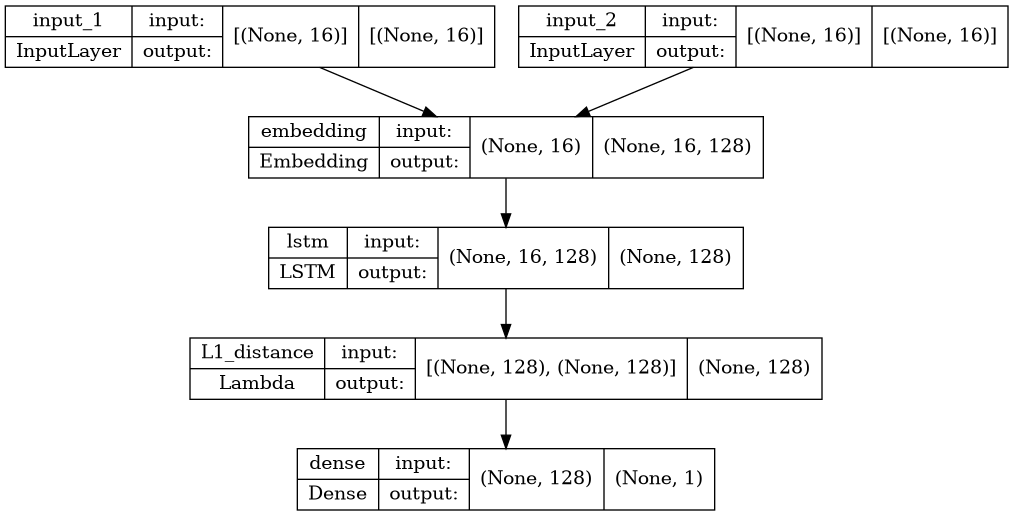

In [54]:
plot_model(model, show_layer_names=True, show_shapes=True )

In [55]:
learning_rate = 9e-3
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [56]:
x_left.shape,target.shape

((4540, 16), (4540, 1))

In [57]:
%%time

n_epochs = 25

history = model.fit( [x_left, x_right], target,epochs = n_epochs, batch_size = 1024, )

Epoch 1/25
5/5 [==============================] - 10s 68ms/step - loss: 1092.1367 - acc: 0.4659
Epoch 2/25
5/5 [==============================] - 0s 50ms/step - loss: 0.3398 - acc: 0.5000
Epoch 3/25
5/5 [==============================] - 0s 45ms/step - loss: 0.3344 - acc: 0.4811
Epoch 4/25
5/5 [==============================] - 0s 47ms/step - loss: 0.2459 - acc: 0.3778
Epoch 5/25
5/5 [==============================] - 0s 48ms/step - loss: 0.1900 - acc: 0.2982
Epoch 6/25
5/5 [==============================] - 0s 39ms/step - loss: 0.1679 - acc: 0.2650
Epoch 7/25
5/5 [==============================] - 0s 41ms/step - loss: 0.1517 - acc: 0.2249
Epoch 8/25
5/5 [==============================] - 0s 44ms/step - loss: 0.1369 - acc: 0.1978
Epoch 9/25
5/5 [==============================] - 0s 41ms/step - loss: 0.1251 - acc: 0.1760
Epoch 10/25
5/5 [==============================] - 0s 41ms/step - loss: 0.1152 - acc: 0.1559
Epoch 11/25
5/5 [==============================] - 0s 43ms/step - loss: 0.1

----

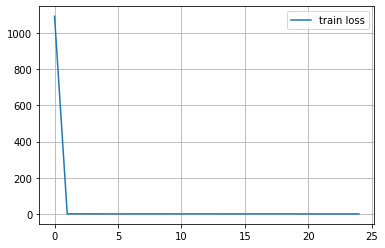

In [58]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

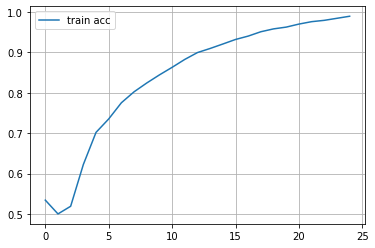

In [59]:
plt.plot( 1. - np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [60]:
# gc.collect()

## тест

In [61]:
# dataset.sample(2)

In [62]:
dataset['dist'] = model.predict([x_left,x_right,])

In [63]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_R','Наименование':'ttext_R'}),on='id_R')\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_L','Наименование':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]

# data_dist.sample(3)

In [64]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,4540.0,0.944135,1.11843,0.0,0.0,0.462495,1.654085,6.550791


In [65]:
# похожие тексты
data_dist[ (data_dist['dist']<0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(10)

,ttext_L,ttext_R,dist
2648,Услуги по розничной торговле крупами в специализированных магазинах,Услуги по розничной торговле молочными продуктами и яйцами в специализированных магазинах,0.000000
4414,Работы строительные по строительству новых сооружений для обрабатывающей промышленности,Работы строительные по ремонту сооружений для обрабатывающей промышленности,0.000000
3930,"Услуги по производству изделий из драгоценных металлов отдельные, выполняемые субподрядчиком","Серебро необработанное или полуобработанное, или в виде порошка",0.000000
4195,Мебель для офисов и предприятий торговли,Столы деревянные для учебных заведений прочие,0.097537
2813,Оборудование для обработки книжных блоков (блокообрабатывающие машины),Машины для крытья брошюр мягкой обложкой,0.288341
2411,Услуги по узкополосному доступу к информационно-коммуникационной сети Интернет по беспроводным сетям,Услуги подвижной связи для целей передачи голоса,0.000000
1138,Проволока холоднотянутая из нержавеющей стали,Проволока биметаллическая сталемедная,0.000000
3292,Топливо для реактивных двигателей летательных аппаратов с дозвуковой скоростью полета,Кокс нефтяной кальцинированный,0.000000
982,"Руды и концентраты свинца, цинка и олова",Концентраты хромовые (хромитовые),0.000000
719,"Форель радужная живая, являющаяся продукцией рыбоводства","Сиг свежий или охлажденный, являющийся продукцией рыбоводства",0.000000


In [66]:
# НЕпохожие тексты
data_dist[ (data_dist['dist']>0.5) ].sample(10)

,ttext_L,ttext_R,dist
2033,"Магнетроны, клистроны, приборы СВЧ и прочие электронные вакуумные или газонаполненные трубки",Кабели для светосигнального оборудования аэродромов,1.351306
543,Бревна строительные и подтоварник из лиственницы,Бульдозеры на колесных тракторах и тягачах,2.278238
1385,Услуги по заграничным и каботажным перевозкам пассажиров морскими паромами,Услуги по монтажу прочего оборудования специального назначения,1.871878
2446,Услуги по сбору и сортировке удаляемых радиоактивных отходов,"Покрытия текстильные напольные тканые прочие, неиглопрошивные или флокированные",1.541084
423,Куры мясных пород прародительского стада,Полуфабрикаты круглого или многоугольного сечения из нелегированной стали прочие,1.236423
4509,Услуги по изготовлению вне павильона черно-белых и цветных художественных фотоснимков,Услуги по установлению рыночной или иной стоимости отдельных материальных объектов (вещей),1.642207
3161,Цилиндры цельные из агломерированной пробки,"Полосы и ленты из меди толщиной более 0,15 мм",0.656783
1303,Субпродукты уток (включая утят) пищевые замороженные,Двигатели летательных аппаратов с искровым зажиганием,2.805947
1253,Сахар-сырец свекловичный в твердом состоянии,"Услуги по изготовлению и прикрепление ремешков, язычков, удлинение ремешков и замена резинок",2.178823
3294,Полотно железнодорожное для железных дорог прочее,Кокс нефтяной кальцинированный,2.449541
